In [1]:
!pip install stanza
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=8e824f805d84e7ddaf75dd5d6c4c032ae7b154f0b999365abc97de2ce5ec590d
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [2]:
import csv
import json

import numpy as np
import pandas as pd
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification

import torch

from tqdm import tqdm
# import os
# import evaluate
# from datasets import load_dataset
# from collections import Counter, defaultdict

# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
GOOGLE_PATH = "drive/MyDrive/si630-project/"

In [5]:
train_file = GOOGLE_PATH + 'merged_train.csv'
dev_file = GOOGLE_PATH + 'merged_dev.csv'
aug_file = GOOGLE_PATH + "all_test.csv"

train_df = pd.read_csv(train_file)
dev_df = pd.read_csv(dev_file)
aug_df = pd.read_csv(aug_file)

In [6]:
all_dataset = load_dataset('csv', data_files={'train': train_file, 'dev': dev_file})
all_dataset = all_dataset.remove_columns(["question_id"])
all_dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d8e7f7fd2371b9a2/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3756
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 3756
    })
})

In [7]:

aug_dataset = load_dataset('csv', data_files={'train': aug_file})
aug_dataset = aug_dataset.remove_columns(["question_id"])
aug_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-01914525cbc93841/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'dataset'],
        num_rows: 4940
    })
})

# Dummy classifiers

In [8]:
mf_dummy_clf = DummyClassifier(strategy="most_frequent")
mf_dummy_clf.fit(train_df.text, train_df.label)
mf_dummy_test_preds = mf_dummy_clf.predict(dev_df.text)
precision_recall_fscore_support(dev_df.label, mf_dummy_test_preds, average='binary')

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0, 0.0, None)

In [9]:
random_dummy_clf = DummyClassifier(strategy="stratified")
random_dummy_clf.fit(train_df.text, train_df.label)
random_dummy_test_preds = random_dummy_clf.predict(dev_df.text)
precision_recall_fscore_support(dev_df.label, random_dummy_test_preds, average='binary')

(0.40361821584529006, 0.41474358974358977, 0.4091052797976604, None)

In [10]:
random_dummy_aug_preds = random_dummy_clf.predict(aug_df.text)
precision_recall_fscore_support(aug_df.label, random_dummy_aug_preds, average='binary')

(0.48739495798319327, 0.4146341463414634, 0.44807998182231307, None)

In [11]:
fpr_dummy, tpr_dummy, threshold = roc_curve(np.array(dev_df.label), random_dummy_test_preds)
auc(fpr_dummy, tpr_dummy)

0.48970330671150347

# Standard sklearn classifier(s)

In [12]:
# Convert text to features using a simple tf-idf
# min_df = is the minimum occurrences for a word to a feature
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(train_df.text.values.astype('U'))

# Train a Logisitic Regression classifier
clf = LogisticRegression()
clf.fit(X_train, train_df.label)

# Test the classifier by converting test data to features
X_test = vectorizer.transform(dev_df.text.values.astype('U'))
y_pred = clf.predict(X_test)
y_true = dev_df.label

# We'll using binary F1 to test whether we can detect sarcastic comments
precision_recall_fscore_support(y_true, y_pred, average='binary')


(0.8611940298507462, 0.7397435897435898, 0.7958620689655173, None)

In [13]:
pred_df = pd.DataFrame({'text': dev_df.text, 'label': dev_df.label, 'predict': y_pred})
pd.set_option('display.max_colwidth', None)
not_match_df = pred_df[pred_df.label != pred_df.predict]
not_match_df

,text,label,predict
15,"Tilting your rearview mirror up at night allows you to see a dimmer version of what's behind you because the mirror is designed to reflect light from the rear of your vehicle. When you tilt the mirror up, the light from the headlights of the vehicles behind you is reflected off the mirror and into your eyes. This can be helpful at night because it allows you to see what's behind you without being blinded by the bright headlights. \r\nThe mirror is not just tilting up to hit the ceiling inside your car. It is still reflecting light, just at a different angle. When you tilt the mirror up, you are changing the angle at which the light is reflected off the mirror and into your eyes. This change in angle causes the light to appear dimmer, which can make it easier to see what's behind you at night.",1,0
51,"Outer space is a vacuum, which means it's a place where there is very little matter, including air. If outer space were filled with air, it would be very different from what we experience on Earth. \r\nOne big difference is that there would be air pressure in outer space. On Earth, the air we breathe is heavy and pushes down on us, which is why we need to wear special suits to go outside in space. If there were air in outer space, it would also push down on us, but in a much weaker way. \r\nAnother difference is that things would be able to move through the air in outer space. Right now, objects in space like satellites and space stations have to use rockets or other special equipment to move around. But if there were air in outer space, they could just use their wings like airplanes do. \r\nOne unpleasant effect on our planet could be that the air in outer space would be very thin and not have enough oxygen for us to breathe. This means that we would still need special equipment to go into outer space, even if there was air. \r\nOverall, having air in outer space would be very different from what we experience on Earth, and it could be difficult for us to adapt to these changes.",1,0
63,"Entropy is a measure of the disorder or randomness of a system. It can be thought of as a way to describe the amount of uncertainty or randomness in a system. \r\nHere's an example to help explain entropy: Imagine you have a jar with 10 red marbles and 10 blue marbles. The jar is organized, with all the red marbles on one side and all the blue marbles on the other side. In this case, the jar has low entropy because everything is very organized and there is little uncertainty about where the marbles are. \r\nNow imagine that you shake the jar up, so that the marbles are mixed together. Now it is difficult to predict where any individual marble will be when you reach into the jar. In this case, the jar has high entropy because there is a lot of randomness and uncertainty about where the marbles are. \r\nIn thermodynamics, entropy is often used to describe the randomness or disorder of a system at the molecular level. For example, when a gas is allowed to expand, the molecules will spread out and become more disordered, resulting in an increase in entropy. Similarly, when a substance is cooled, the molecules will slow down and become more organized, resulting in a decrease in entropy. \r\nI hope this helps to give you a basic understanding of entropy! Let me know if you have any more questions.",1,0
73,Some herbal concoctions can reduce fertility or induce abortion .,0,1
83,"When you are driving by a siren, the pitch of the sound seems to change because of something called the Doppler effect. The Doppler effect is a change in the frequency or pitch of a sound wave that occurs when the source of the sound and the listener are moving relative to each other. \r\nFor example, when a siren on an ambulance is approaching you, the sound waves it is emitting are compressed, or squeezed together. This makes the pitch of the siren sound higher. As the ambulance passes by you and moves away, the sound waves it is emitting are stretched

In [14]:
fpr_sk, tpr_sk, threshold = roc_curve(np.array(y_true), y_pred)
auc(fpr_sk, tpr_sk)

0.8275220680958386

In [15]:
aug_X_test = vectorizer.transform(aug_df.text.values.astype('U'))
aug_y_pred = clf.predict(aug_X_test)
aug_y_true = aug_df.label

# We'll using binary F1 to test whether we can detect sarcastic comments
precision_recall_fscore_support(aug_y_true, aug_y_pred, average='binary')

fpr_sk_aug, tpr_sk_aug, threshold = roc_curve(np.array(aug_y_true),aug_y_pred)
auc(fpr_sk_aug, tpr_sk_aug)

0.5975084514634211

# Fancy Huggingface classifiers

We'll use [MiniLM](https://huggingface.co/microsoft/MiniLM-L12-H384-uncased) which is a compressed version of a BERT-like model that is faster to train

In [16]:
torch.cuda.is_available()

True

In [17]:
# Verify there's at least one GPU sitting around (or not if you want to try CPU!)
torch.cuda.device_count()

1

In [18]:
all_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3756
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 3756
    })
})

### Prepare the text

We need to tokenize the data. Each large language model (LLM) has its own tokenizer, so we will have to specify how the model expects the text to be turned into tokens. In huggingface, we'll specify a LLM using a string name, e.g., "microsoft/MiniLM-L12-H384-uncased" for MiniLM. You can see more details on different possible model on Huggingface's [model repo](https://huggingface.co/models)

In [19]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_all = all_dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/3756 [00:00<?, ? examples/s]

Map:   0%|          | 0/3756 [00:00<?, ? examples/s]

### Train the model

In [20]:
# Huggingface will generate model checkpoints and these can
# take up a lot of space, so be sure to set this directory somewhere where
# you can check

output_dir = '.'

# This code block is used so we can have a deterministic training procedure
# (i.e., get the same result each time)
model_name = "microsoft/MiniLM-L12-H384-uncased"


def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    learning_rate=8e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    do_eval=True,
    seed=1234,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    logging_dir=output_dir + 'logs/',
    label_smoothing_factor=0.1,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_all["train"],
    eval_dataset=tokenized_all["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast t

Epoch,Training Loss,Validation Loss
1,No log,0.290322


TrainOutput(global_step=470, training_loss=0.34392541114320146, metrics={'train_runtime': 133.1998, 'train_samples_per_second': 28.198, 'train_steps_per_second': 3.529, 'total_flos': 165678664953648.0, 'train_loss': 0.34392541114320146, 'epoch': 1.0})

In [21]:
trainer.evaluate()

{'eval_loss': 0.2903224527835846,
 'eval_runtime': 30.1161,
 'eval_samples_per_second': 124.717,
 'eval_steps_per_second': 15.606,
 'epoch': 1.0}

In [22]:
dev_logits = trainer.predict(tokenized_all["dev"])
print(dev_logits.predictions.shape, dev_logits.label_ids.shape)
dev_preds = np.argmax(dev_logits.predictions, axis=-1)
precision_recall_fscore_support(dev_df.label, dev_preds, average='binary')

(3756, 2) (3756,)


(0.9080257762155829, 0.9935897435897436, 0.9488827670645853, None)

In [23]:
tokenized_aug = aug_dataset.map(preprocess_function, batched=True)

aug_dev_logits = trainer.predict(tokenized_aug["train"])
print(aug_dev_logits.predictions.shape, aug_dev_logits.label_ids.shape)
aug_dev_preds = np.argmax(aug_dev_logits.predictions, axis=-1)
fpr_hf_aug, tpr_hf_aug, threshold = roc_curve(np.array(aug_df.label), aug_dev_preds)
auc(fpr_hf_aug, tpr_hf_aug)

Map:   0%|          | 0/4940 [00:00<?, ? examples/s]

(4940, 2) (4940,)


0.7206133966774537

In [24]:
fpr_hf, tpr_hf, threshold = roc_curve(np.array(dev_df.label), dev_preds)
auc(fpr_hf, tpr_hf)

0.9610480594087152

### LR with syn

In [25]:
import stanza
from collections import defaultdict

def deprel_func(sentences, nlp):
    doc = nlp(sentences)
    deprel_dist = defaultdict(int)
    for sent in doc.sentences:
        for word in sent.words:
            deprel_dist[word.deprel] += 1
    return deprel_dist

nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


In [26]:
deprel_dist = [deprel_func(sent, nlp) for sent in tqdm(train_df['text'])]
keys = set().union(*(d.keys() for d in deprel_dist))

deprel_dist_dev = [deprel_func(sent, nlp) for sent in tqdm(dev_df['text'])]
deprel_dist_test = [deprel_func(sent, nlp) for sent in tqdm(aug_df['text'])]

train_list = [{k: d.get(k, 0) for k in keys} for d in deprel_dist]
dev_list = [{k: d.get(k, 0) for k in keys} for d in deprel_dist_dev]
aug_list = [{k: d.get(k, 0) for k in keys} for d in deprel_dist_test]

100%|██████████| 4940/4940 [08:05<00:00, 10.18it/s]


In [27]:
train_syn = pd.DataFrame(train_list)
train_mean = train_syn.mean(axis=0)
train_std = train_syn.std(axis=0)
dev_syn = pd.DataFrame(dev_list)
aug_syn = pd.DataFrame(aug_list)

train_syn = (train_syn - train_mean) / train_std
dev_syn = (dev_syn - train_mean) / train_std
aug_syn = (aug_syn - train_mean) / train_std

In [28]:
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(train_df.text.values.astype('U'))
X_train = np.concatenate((X_train.toarray(), train_syn.to_numpy()), axis=1)

# Train a Logisitic Regression classifier
clf = LogisticRegression()
clf.fit(X_train, train_df.label)

# Test the classifier by converting test data to features
X_test = vectorizer.transform(dev_df.text.values.astype('U'))
X_test = np.concatenate((X_test.toarray(), dev_syn.to_numpy()), axis=1)
y_pred = clf.predict(X_test)
y_true = dev_df.label

# We'll using binary F1 to test whether we can detect sarcastic comments
precision_recall_fscore_support(y_true, y_pred, average='binary')

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.8479571332886805, 0.8115384615384615, 0.8293481821159515, None)

In [29]:
fpr_syn, tpr_syn, threshold = roc_curve(np.array(y_true) , y_pred)
auc(fpr_syn, tpr_syn)

0.8540843491663164

In [30]:
X_test = vectorizer.transform(aug_df.text.values.astype('U'))
X_test = np.concatenate((X_test.toarray(), aug_syn.to_numpy()), axis=1)
y_pred = clf.predict(X_test)
y_true = aug_df.label

# We'll using binary F1 to test whether we can detect sarcastic comments
precision_recall_fscore_support(y_true, y_pred, average='binary')

(0.60345789180145, 0.45500420521446594, 0.5188204267561736, None)

In [31]:
fpr_syn_aug, tpr_syn_aug, threshold = roc_curve(np.array(y_true) , y_pred)
auc(fpr_syn_aug, tpr_syn_aug)

0.5887433204058279

### Visualization

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-34-9afdfd11d557>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


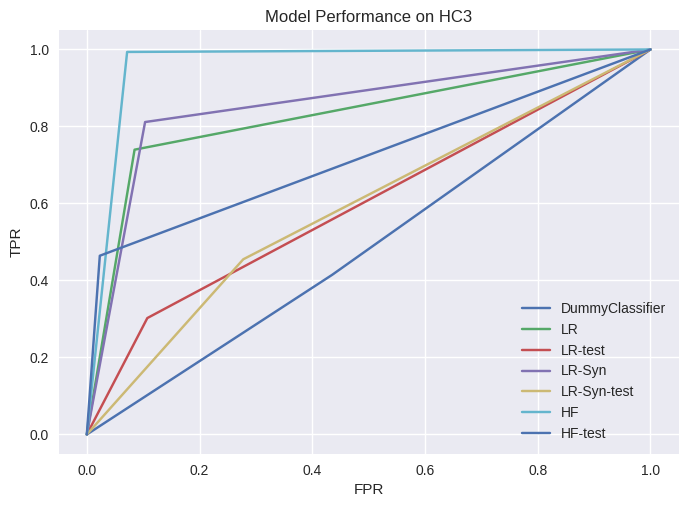

In [34]:
plt.style.use("seaborn")
plt.plot(fpr_dummy, tpr_dummy)
plt.plot(fpr_sk, tpr_sk)
plt.plot(fpr_sk_aug, tpr_sk_aug)
plt.plot(fpr_syn, tpr_syn)
plt.plot(fpr_syn_aug, tpr_syn_aug)
plt.plot(fpr_hf, tpr_hf)
plt.plot(fpr_hf_aug, tpr_hf_aug)
plt.legend(['DummyClassifier', 'LR', 'LR-test', 'LR-Syn', 'LR-Syn-test', 'HF', 'HF-test'])
plt.title("Model Performance on HC3")
plt.xlabel("FPR")
plt.ylabel("TPR")
# plt.xscale('log')
# plt.yscale('log')
plt.savefig("res")